# Laporan Proyek Mini: Klasifikasi Aksara Jawa Tulisan Tangan Menggunakan CNN

### Kelompok
- Rizky Cahyono Putra
- Raffa Arvel Nafi’Nadindra
- Syaifan Nur
- Irfansyah
- Muhammad Galang Fachrezy


### Pendahuluan
Proyek ini bertujuan untuk membangun sebuah model *deep learning* yang mampu mengenali dan mengklasifikasikan gambar aksara Jawa tulisan tangan. Kami menggunakan arsitektur **Convolutional Neural Network (CNN)** yang dibangun dari awal (from scratch) dengan framework **TensorFlow/Keras**. Dataset yang digunakan adalah kumpulan gambar aksara Jawa yang telah dipisahkan ke dalam folder sesuai dengan kelasnya. Laporan ini akan menjabarkan seluruh proses, mulai dari persiapan data, perancangan model, pelatihan, hingga evaluasi performa.

## Setup Awal Library
*Penjelasan*: Langkah pertama adalah menyiapkan lingkungan kerja. Kami mengimpor semua library yang diperlukan dan mendefinisikan parameter-parameter utama dalam sebuah class Konfigurasi agar mudah diubah untuk eksperimen.

In [125]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

print('library berhasil di import')

library berhasil di import


## Konfig-konfig Awal Project

In [126]:
class Konfigurasi:
    DATA_PATH = "/kaggle/input/hanacaraka"
    
    # pengaturan gambar
    IMAGE_SIZE = (64, 64)
    BATCH_SIZE = 32

    # jumlah epoch
    EPOCHS = 100

config = Konfigurasi()

## Memuat dan Mempersiapkan Dataset
*Penjelasan*: Kami menggunakan fungsi image_dataset_from_directory dari Keras untuk memuat data. Fungsi ini sangat efisien karena secara otomatis membaca gambar dari sub-folder dan menetapkan nama folder sebagai label kelas. Kami juga membagi data menjadi 80% untuk pelatihan dan 20% untuk validasi.

In [127]:
# menggunakan 80% data untuk training


train_ds = tf.keras.utils.image_dataset_from_directory(
    config.DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE,
    color_mode='grayscale' 
)

# menggunakan 20% data untuk validasi
val_ds = tf.keras.utils.image_dataset_from_directory(
    config.DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE,
    color_mode='grayscale'
)

# mendapatkan nama class dataset
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Ditemukan {NUM_CLASSES} kelas (aksara):")
print(class_names)

Found 1562 files belonging to 20 classes.
Using 1250 files for training.
Found 1562 files belonging to 20 classes.
Using 312 files for validation.
Ditemukan 20 kelas (aksara):
['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']


## Visualisasi Data & Ekspolorasi
*Penjelasan*: Sebelum melatih model, penting untuk melihat seperti apa data yang kita gunakan. Sel ini akan menampilkan beberapa contoh gambar dari dataset pelatihan beserta labelnya.

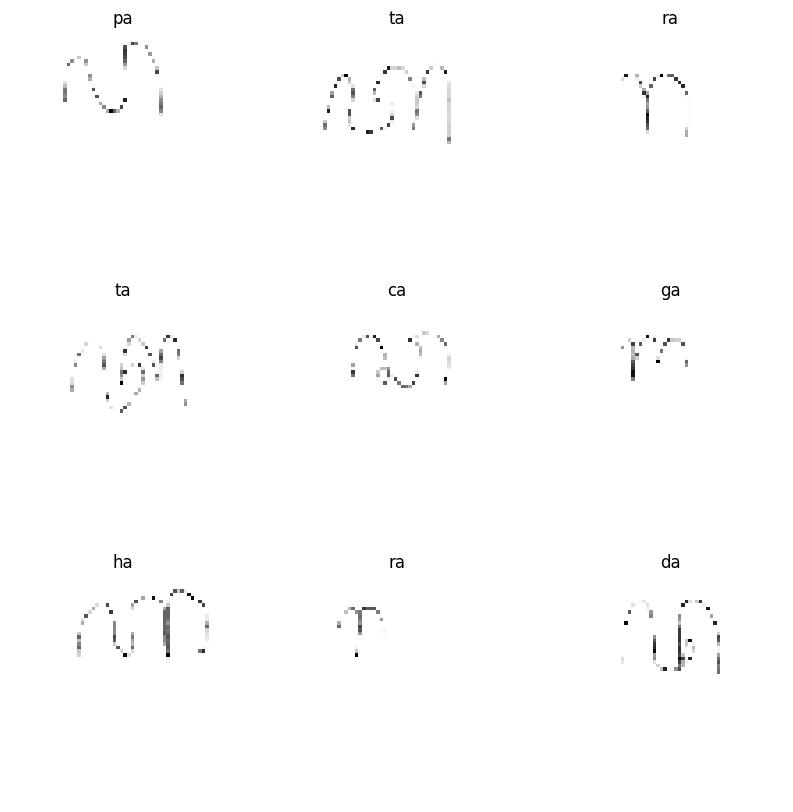

In [128]:
# visualisasi beberapa contoh gambar
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # Ambil satu batch pertama
    for i in range(9): # Tampilkan 9 gambar pertama dari batch
        ax = plt.subplot(3, 3, i + 1)
        # Reshape dari (64, 64, 1) menjadi (64, 64) untuk ditampilkan
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## Optimasi Performa Dataset
*Penjelasan*: Untuk mempercepat proses training, kami menggunakan metode .cache() dan .prefetch(). .cache() akan menyimpan data di memori setelah pertama kali dimuat, dan .prefetch() akan menyiapkan batch data berikutnya saat GPU sedang memproses batch saat ini.

In [129]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print('optimasi selesai')

optimasi selesai


## Merancang Arsitektur CNN

*Penjelasan*: Kami membangun model CNN dari awal menggunakan Keras Sequential API. Arsitekturnya terdiri dari beberapa blok konvolusi untuk ekstraksi fitur dan lapisan Dense untuk klasifikasi. Kami juga menambahkan data augmentation untuk membuat model lebih robust dan Dropout untuk mencegah overfitting.

In [130]:
model = models.Sequential([
    # Lapisan Augmentasi & Normalisasi
    layers.Input(shape=(config.IMAGE_SIZE[0], config.IMAGE_SIZE[1], 1)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),

    # Blok Konvolusi 1
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=0.2), # GANTI 'relu' dengan LeakyReLU
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Blok Konvolusi 2
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=0.2), # GANTI 'relu' dengan LeakyReLU
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Blok Konvolusi 3
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.LeakyReLU(alpha=0.2), # GANTI 'relu' dengan LeakyReLU
    layers.MaxPooling2D((2, 2)),

    # Lapisan Klasifikasi
    layers.Flatten(),
    layers.Dense(256),
    layers.LeakyReLU(alpha=0.2), # GANTI 'relu' dengan LeakyReLU
    layers.Dropout(0.5), 
    layers.Dense(NUM_CLASSES) # Output logit (tanpa aktivasi)
])

# Kompilasi ulang dengan learning rate rendah
optimizer_kustom = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer_kustom,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_14 (RandomFlip)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_14              │ (None, 64, 64, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_14 (RandomZoom)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,570,132 (17.43 MB)

 Trainable params: 4,569,748 (17.43 MB)

 Non-trainable params: 384 (1.50 KB)

## Melatih model CNN
*Penjelasan*: Ini adalah tahap implementasi utama di mana kami melatih model menggunakan data training dan mengevaluasinya pada setiap epoch menggunakan data validasi. Proses ini akan memakan waktu tergantung pada hardware yang digunakan.

In [131]:
print("Memulai proses pelatihan model...")

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, # Kurangi LR sebesar 80% (1 - 0.2)
    patience=5, 
    min_lr=1e-6 # Learning rate minimum
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.EPOCHS,
    callbacks=[early_stopping]
)
print("Pelatihan model selesai.")

Memulai proses pelatihan model...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0549 - loss: 3.7565 - val_accuracy: 0.0288 - val_loss: 3.0037
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0555 - loss: 3.2767 - val_accuracy: 0.0577 - val_loss: 3.0017
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0630 - loss: 3.1146 - val_accuracy: 0.0481 - val_loss: 3.0016
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0708 - loss: 3.0741 - val_accuracy: 0.0737 - val_loss: 2.9947
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0726 - loss: 3.0590 - val_accuracy: 0.0609 - val_loss: 2.9976
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0711 - loss: 3.0390 - val_accuracy: 0.0545 - val_loss: 2.9960
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0662 - loss: 3.0630 - val_accuracy: 0.0673 - val_loss: 2.9764
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0964

## Evaluasi Hasil 
*Penjelasan*: Setelah training selesai, kami memvisualisasikan grafik akurasi dan loss untuk data training dan validasi. Grafik ini sangat penting untuk menganalisis apakah model mengalami *overfitting* atau *underfitting*.

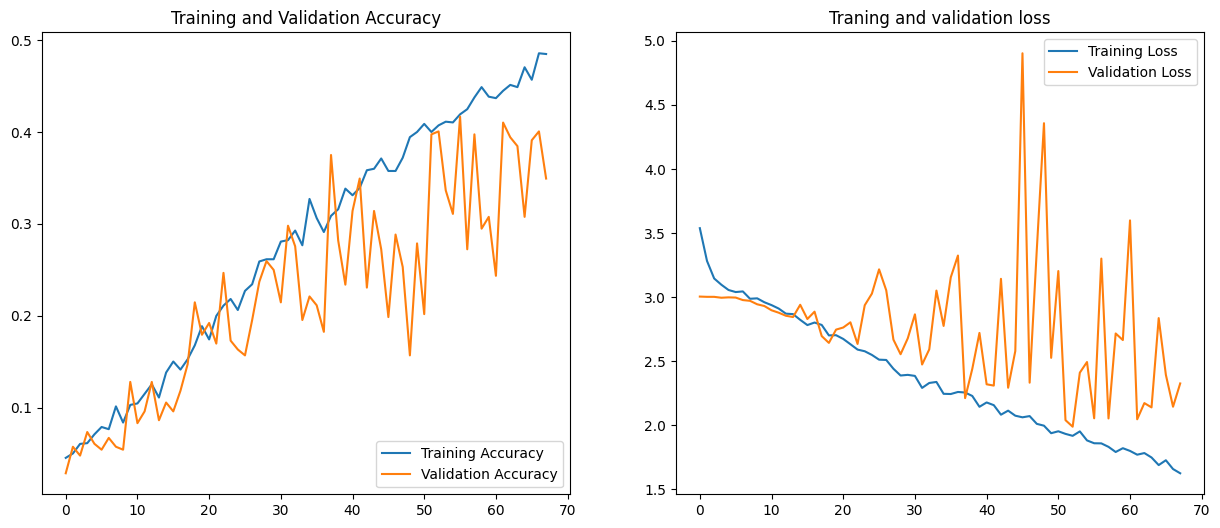

In [132]:
# ambil data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# plot
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Traning and validation loss')
plt.show()

## Analisis Performa dengan Confusion Matrix
*Penjelasan*: Untuk memahami performa model lebih dalam, kami menggunakan Confusion Matrix. Matriks ini menunjukkan kelas mana saja yang sering salah diklasifikasikan oleh model.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


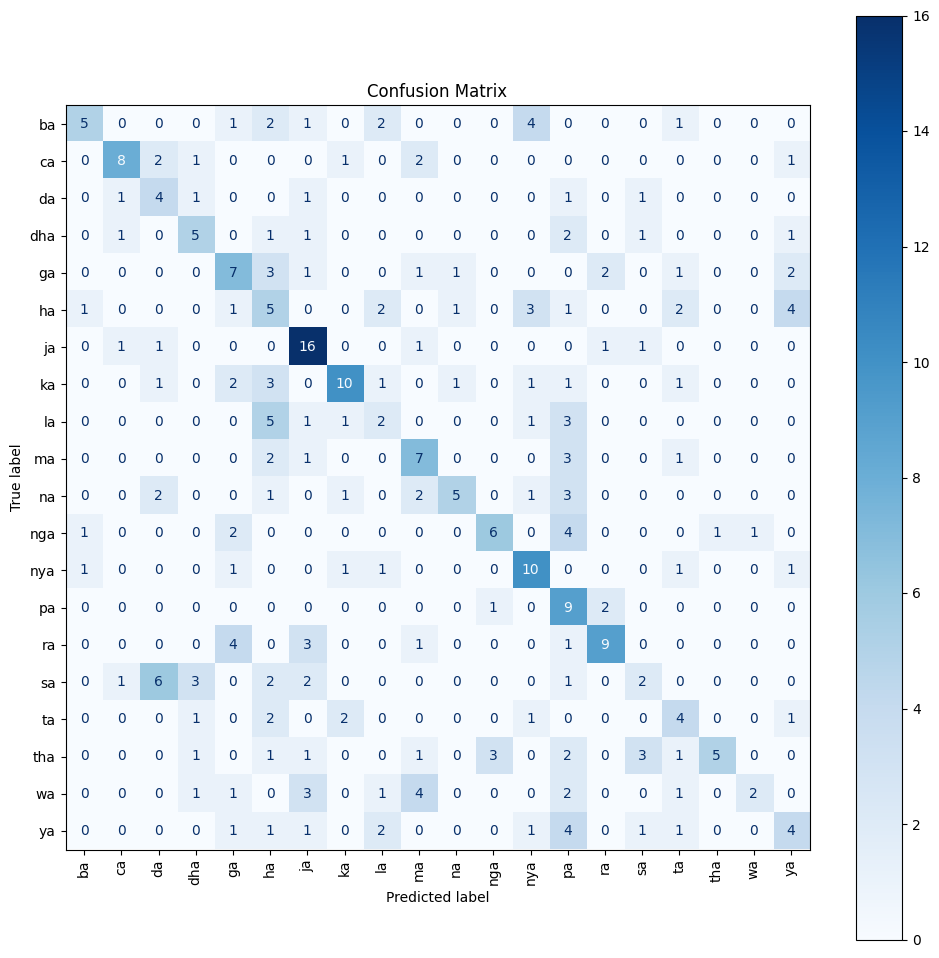

In [133]:
# --- Membuat Prediksi pada Data Validasi ---
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Mendapatkan Label Asli ---
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# --- Menghitung dan Menampilkan Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


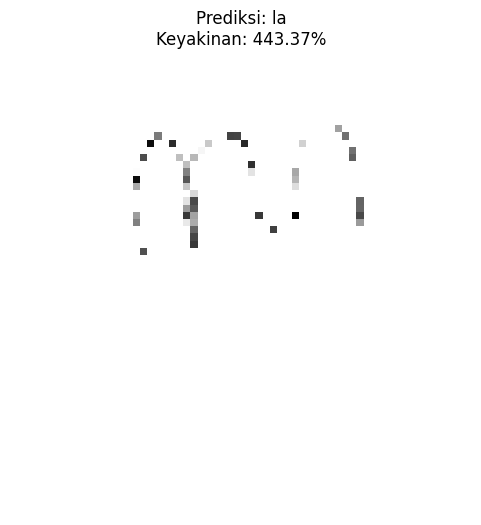

In [138]:
def prediksi_gambar_tunggal(img_path):
    try:
        # Memuat gambar menggunakan Keras
        img = tf.keras.utils.load_img(
            img_path,
            target_size=config.IMAGE_SIZE,
            color_mode='grayscale'
        )

        # Mengubah gambar menjadi array NumPy
        img_array = tf.keras.utils.img_to_array(img)
        # Menambahkan dimensi batch (menjadi 1, 64, 64, 1)
        img_array = tf.expand_dims(img_array, 0)

        # Melakukan prediksi
        predictions = model.predict(img_array)
        
        # Mendapatkan kelas dengan probabilitas tertinggi
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_names[predicted_class_index]
        confidence = 100 * np.max(predictions[0])

        # Menampilkan hasil
        plt.figure(figsize=(6, 6))
        plt.imshow(np.squeeze(img_array[0]), cmap='gray')
        plt.title(f"Prediksi: {predicted_class_name}\nKeyakinan: {confidence:.2f}%")
        plt.axis("off")
        plt.show()

    except FileNotFoundError:
        print(f"ERROR: File tidak ditemukan di '{img_path}'.")
        print("Pastikan path yang Anda masukkan sudah benar.")
    except Exception as e:
        print(f"Terjadi error: {e}")


# --- CONTOH PENGGUNAAN ---
# Ganti path di bawah ini dengan path ke salah satu gambar dari dataset Anda
# Contoh path di Kaggle: '/kaggle/input/hanacaraka/ha/ha_1.png'
PATH_GAMBAR_UJI = "/kaggle/input/hanacaraka/la/4693403521314974166_base64_27.png"

prediksi_gambar_tunggal(PATH_GAMBAR_UJI)